In [1]:
# TODO: revert to ludwig-ai repo when issue #1885 fixed
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
#!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

!python -m pip install git+https://github.com/jimthompson5802/ludwig.git@fix-iss1885-roc-curve-viz-error  --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 398 kB 5.6 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 136 kB 72.2 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 271 kB 50.6 MB/s 
     |████████████████████████████████| 144 kB 67.5 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 


In [2]:
!ludwig datasets download adult_census_income

NumExpr defaulting to 2 threads.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Datasets download



In [3]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('./adult_census_income.csv')
raw_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,split
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [4]:
config_yaml = """
preprocessing:
  number:
    normalization: zscore
    missing_value_strategy: fill_with_mean

input_features:
  - name: age
    type: number
  - name: workclass
    type: category
  - name: fnlwgt
    type: number
  - name: education
    type: category
  - name: education-num
    type: number
  - name: marital-status
    type: category
  - name: occupation
    type: category
  - name: relationship
    type: category
  - name: race
    type: category
  - name: sex
    type: category
  - name: capital-gain
    type: number
  - name: capital-loss
    type: number
  - name: hours-per-week
    type: number
  - name: native-country
    type: category

combiner:
  type: concat
  num_fc_layers: 3
  output_size: 128
  dropout: 0.2

output_features:
  - name: income
    type: binary
    preprocessing:
      fallback_true_label: " >50K"
    num_fc_layers: 4
    output_size: 32

trainer:
  epochs: 10
  optimizer: 
    type: adam
"""

# Writes config to a file called "config.yaml"
with open("config.yaml", "w") as f:
  f.write(config_yaml)

In [10]:
# Trains the model. This cell might take a few minutes.
!ludwig experiment --dataset adult_census_income.csv \
              --config config.yaml \
              --logging_level warning

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
Binary feature income has at least 1 unconventional boolean value: Cannot automatically map value  <=50K to a boolean and no `fallback_true_label` specified.. We will now interpret  >50K as 1 and the other values as 0. If this is incorrect, please use the category feature type or manually specify the true value with `preprocessing.fallback_true_label`.
Note: steps_per_checkpoint (was 255) is now set to the number of steps per epoch: 255.



In [11]:
# Extract subset of test data for evaluation due to limitations in amount of data displayable in colab notebook.
np.random.seed(13)
raw_df.loc[raw_df.split == 2].sample(n=200).to_csv('evaluation_dataset.csv', index=False)

In [12]:
# Generates predictions and performance statistics for the test set.
!ludwig evaluate --model_path results/experiment_run/model \
                 --dataset evaluation_dataset.csv \
                 --split full \
                 --output_directory test_results

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Evaluate

Dataset path: evaluation_dataset.csv
Model path: results/experiment_run/model

  embedding_size (50) is greater than vocab_size (10). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (17). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (8). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (16). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (7). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (6). Setting embedding size to be equal to vocab_size.
  embeddin

# Visualize Metrics

In [13]:
!ludwig visualize --visualization roc_curves \
                  --ground_truth adult_census_income.csv \
                  --split_file adult_census_income.split.csv \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --probabilities results/experiment_run/predictions.parquet \
                  --output_feature_name income \
                  --output_directory visualizations \
                  --model_names Model1 \
                  --file_format png


NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


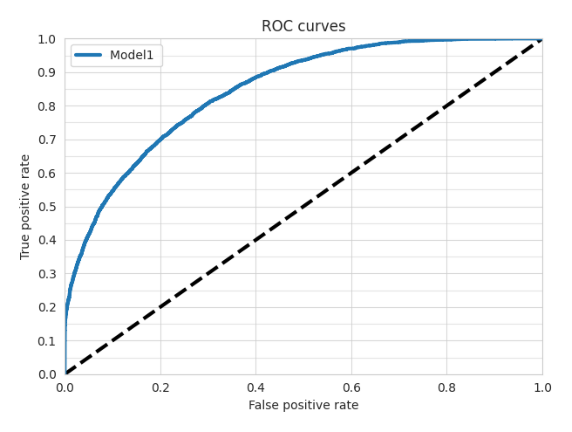

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,14))

plt.imshow(plt.imread("visualizations/roc_curves.png"))
ax.axis("off")
plt.show()

In [15]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
!ludwig visualize --visualization learning_curves \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --training_statistics results/experiment_run/training_statistics.json \
                  --file_format png \
                  --output_directory visualizations

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


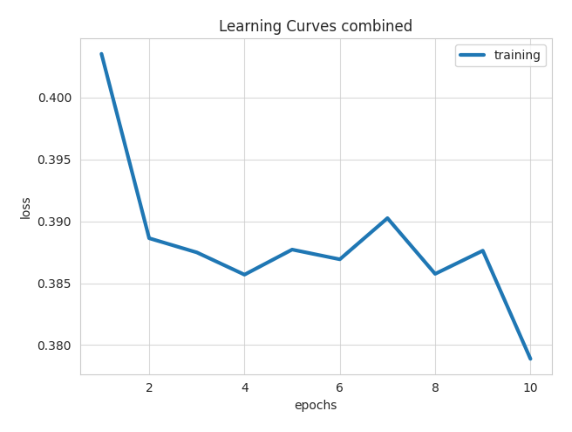

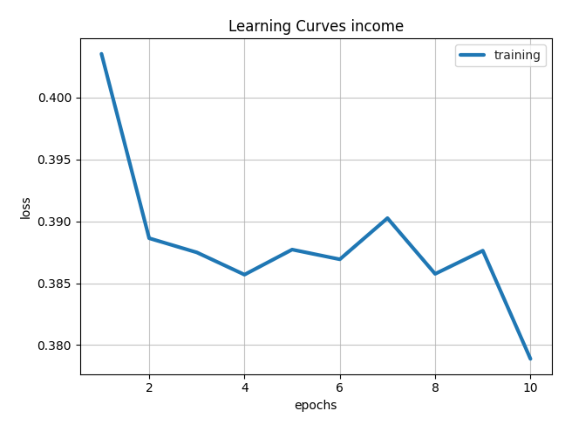

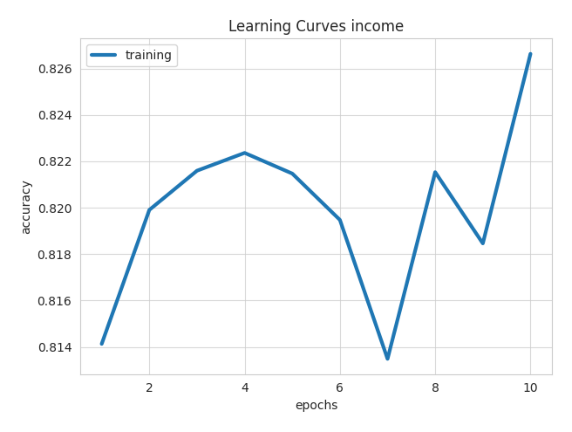

In [16]:
# file paths of the generated plots
plot_fps = ["visualizations/learning_curves_combined_loss.png", "visualizations/learning_curves_income_loss.png",
            "visualizations/learning_curves_income_accuracy.png"]

# dispaly learning curve plots
for fp in plot_fps:
  # setup figure for plotting
  fig, ax = plt.subplots(figsize=(10, 10))
  
  # display generated plot
  ax.imshow(plt.imread(fp))
  ax.axis('off')

plt.show()